In [48]:
import pandas as pd
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

DATA CLEANING AND PREPARATION

In [49]:
img = cv2.imread('./datatest/diana_silvers.jpeg')
img.shape

(425, 297, 3)

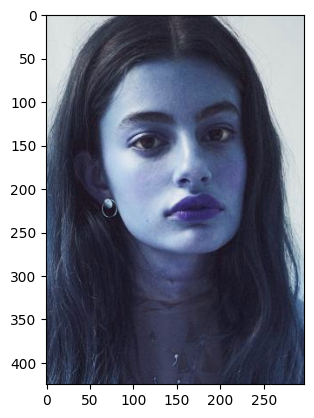

In [50]:
plt.imshow(img)

In [51]:
# create gray image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
gray

(425, 297)


array([[221, 221, 220, ..., 213, 214, 213],
       [221, 221, 220, ..., 213, 214, 213],
       [221, 221, 220, ..., 213, 214, 213],
       ...,
       [ 40,  51,  83, ...,  55,  60,  85],
       [ 39,  48, 105, ...,  58,  63,  82],
       [ 31, 102,  78, ...,  56,  69,  85]], dtype=uint8)

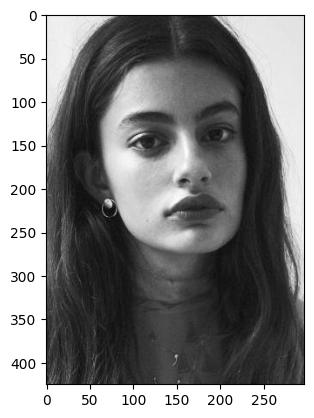

In [52]:
# visualize gray image
plt.imshow(gray, cmap='gray')

In [53]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray,1.3,5)
faces

array([[ 45,  53, 224, 224]])

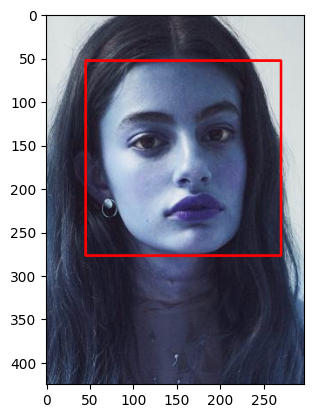

In [54]:
# lets detect the face
(x,y,w,h) = faces[0]
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # (255,0,0) is our color(red for now)
plt.imshow(face_img)

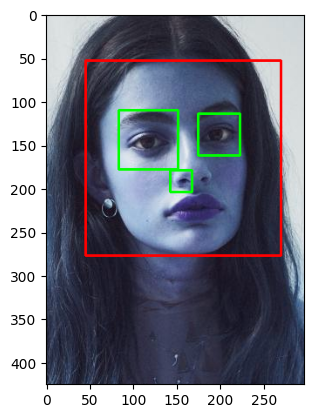

In [55]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = face_img[y:y+h,x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
plt.figure()
plt.imshow(face_img,cmap='gray')
plt.show()

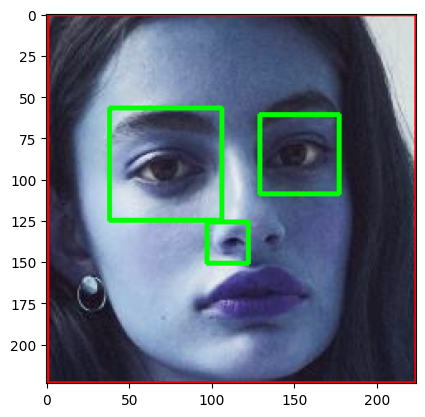

In [56]:
%matplotlib inline
plt.imshow(roi_color,cmap='gray')
# we see that opencv cv detect eyes correct but it detect a nose as an eye

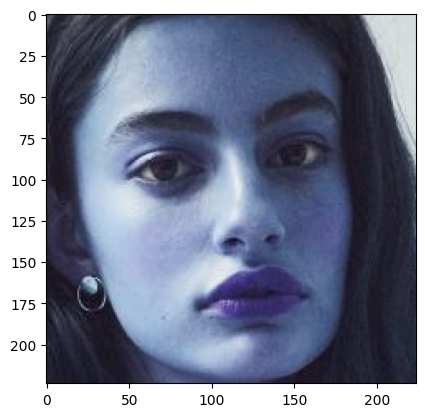

In [57]:
# Lets create a function for detect eyes on any image . Person must have two eyes on image!!!!

def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = img[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >=2:
            return roi_color

cropped_image = get_cropped_image_if_2_eyes('./datatest/diana_silvers.jpeg')
plt.imshow(cropped_image)  
# we got an cropped face image of our celebrity  

In [58]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [59]:
# get all paths of images
import os

img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
        
img_dirs

['./dataset/bridgette_lundy',
 './dataset/cara_del',
 './dataset/diana_silvers',
 './dataset/lana_del_rey',
 './dataset/toby_maguire']

In [60]:
import shutil

if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

After the code below is executed, do not forget to delete unnecessary photos from the folders in the "croppped" folder
If you want to add new celebrities to the dataset folder and re-run the code, it is recommended that you delete the old cropped folder.

In [61]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data+celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating croppped images in folder: ", cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count +=1

Generating croppped images in folder:  ./dataset/cropped/bridgette_lundy
Generating croppped images in folder:  ./dataset/cropped/cara_del
Generating croppped images in folder:  ./dataset/cropped/diana_silvers
Generating croppped images in folder:  ./dataset/cropped/lana_del_rey
Generating croppped images in folder:  ./dataset/cropped/toby_maguire


RESULT OF THE CODE ABOVE

![jupyter](./result.jpg)

FEATURE ENGINEERING 

In [62]:
import pywt

def w2d(img,mode='hear',level=1):
    imArray = img
    #convert to grayscale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray = np.float32(imArray)
    imArray/= 255
    coeffs = pywt.wavedec2(imArray,mode,level=level)
    
    coeffs_H =list(coeffs)
    coeffs_H[0] *= 0

    # reconstruction
    imArray_H = pywt.waverec2(coeffs_H,mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

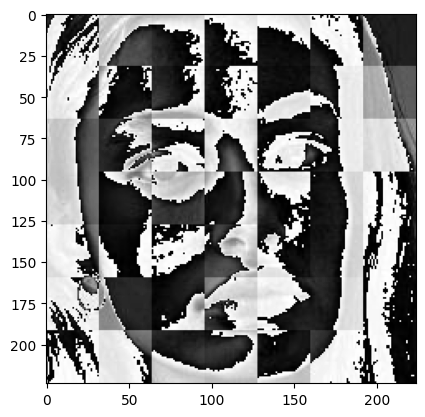

In [63]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har,cmap = 'gray')

In [74]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

In [75]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count+=1
class_dict

{'bridgette_lundy': 0,
 'cara_del': 1,
 'diana_silvers': 2,
 'lana_del_rey': 3,
 'toby_maguire': 4}

In [76]:
X, y = [], []
for celebrity_name,training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img,(32,32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har,(32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [77]:
X[0]

array([[  4],
       [  6],
       [ 14],
       ...,
       [  5],
       [250],
       [  8]], dtype=uint8)

In [78]:
len(X[0])

4096

In [79]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(318, 4096)

TRAINING OUR MODEL

First we will use SVM with rbf kernel

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [88]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

pipe = Pipeline([('scaler', StandardScaler()), ('svc',SVC(kernel='rbf',C=10))])
pipe.fit(x_train,y_train)
pipe.score(x_test,y_test)

0.859375

In [90]:
print(classification_report(y_test,pipe.predict(x_test)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       1.00      0.77      0.87        13
           2       0.64      0.88      0.74         8
           3       0.81      0.87      0.84        15
           4       1.00      0.89      0.94        18

    accuracy                           0.86        64
   macro avg       0.85      0.86      0.85        64
weighted avg       0.88      0.86      0.86        64



Now let's use GridSearch to try out different models with different parametrs.
 Goal is to come up with the best model with best fine tuned parametrs

In [94]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [95]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10,40]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [96]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df


,model,best_score,best_params
0,svm,0.712549,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.582588,{'randomforestclassifier__n_estimators': 40}
2,logistic_regression,0.716157,{'logisticregression__C': 1}


In [98]:
best_estimators['svm'].score(x_test,y_test)
best_clf = best_estimators['svm']

In [99]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(x_test))
cm

array([[ 9,  0,  1,  0,  0],
       [ 1, 11,  0,  1,  0],
       [ 1,  0,  7,  0,  0],
       [ 0,  1,  3, 11,  0],
       [ 1,  0,  1,  0, 16]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

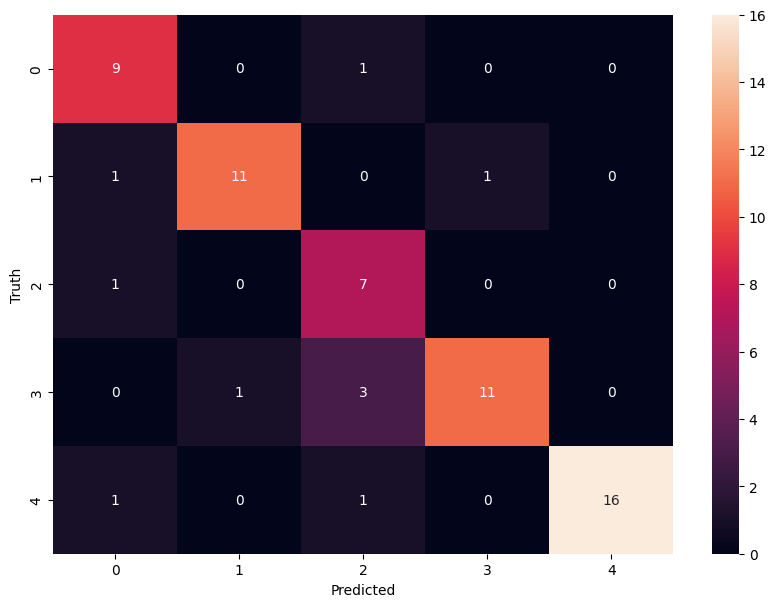

In [100]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

SAVE THE TRAINED MODEL

In [101]:
import joblib
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [102]:
#save class dictionary
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))